In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DDPG
from stable_baselines3 import HerReplayBuffer
from stable_baselines3.common.env_checker import check_env

import matplotlib.pyplot as plt

sys.path.append('..')

import MazeEnv.MazeEnv as mz
from MazeEnv.MazeEnv import Rewards
from Evaluation import EvalAndSaveCallback
import Evaluation


import torch
print("cuda available:", torch.cuda.is_available())

cuda available: True


In [24]:
def make_circular_map(size, radius):
    center = np.divide(size, 2)
    x, y = np.ogrid[:size[0], :size[1]]
    maze_map = np.where(np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2) > radius, 1, 0)

    return maze_map

In [70]:
START_LOC = (5, 2.8)
TIMEOUT_STEPS = 300
BUFFER_SIZE = 1000 # smaller buffer for small task
TOTAL_TIME_STEPS = 100000
LEARNING_RATE = 0.001

REWARDS = Rewards(target_arrival=1, collision=-1, timeout=-0.5, idle=-0.01)

EVAL_EPISODES=1
EVAL_FREQ=100000
VIDEO_FREQ=4

In [71]:
# create environment :
tile_size = 0.1
maze_size = mz.MazeSize.SQUARE10
map_size = np.dot(maze_size, int(1 / tile_size))
maze_map = make_circular_map(map_size, 3 / tile_size)
# maze_map = np.zeros(map_size)

maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                              maze_map=maze_map,
                              tile_size=tile_size,
                              start_loc=START_LOC,
                              target_loc=np.divide(maze_size, 2),
                              timeout_steps=TIMEOUT_STEPS,
                              show_gui=False,
                              rewards=REWARDS), 
                  filename="logs/DummyMaze/results")
_ = maze_env.reset()

check_env(maze_env)

# create separete evaluation environment:
eval_maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                                   maze_map=maze_map,
                                   tile_size=tile_size,
                                   start_loc=START_LOC,
                                   target_loc=np.divide(maze_size, 2),
                                   timeout_steps=TIMEOUT_STEPS,
                                   show_gui=False,
                                   rewards=REWARDS)
                       )
_ = eval_maze_env.reset()
 
# create model:
model = DDPG(policy="MultiInputPolicy",
             env=maze_env,
             buffer_size=BUFFER_SIZE,
             learning_rate=LEARNING_RATE,
             device='cuda',
             train_freq=(1, "episode"),
             verbose=1)

# create callback for evaluation
callback = EvalAndSaveCallback(log_dir="logs/DummyMaze",
                               eval_env=eval_maze_env,
                               eval_freq=EVAL_FREQ,
                               eval_episodes=EVAL_EPISODES,
                               eval_video_freq=VIDEO_FREQ,
                               verbose=0)

argv[0]=
argv[0]=
Using cuda device
Wrapping the env in a DummyVecEnv.


In [ ]:
start = time.time()
torch.manual_seed(0)
model.learn(total_timesteps=TOTAL_TIME_STEPS,
            callback=callback,)

print("time", time.time() - start)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | -1.2     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2615     |
|    time_elapsed    | 0        |
|    total timesteps | 82       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | -1.13    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1261     |
|    time_elapsed    | 0        |
|    total timesteps | 111      |
| train/             |          |
|    actor_loss      | 0.225    |
|    critic_loss     | 0.119    |
|    learning_rate   | 0.001    |
|    n_updates       | 11       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.9     |
|    ep_rew_mean     | -1.1     |
| time/       

In [ ]:
Evaluation.plot_train_eval_results("logs/DummyMaze", EVAL_EPISODES)

Reward: -30.400000000000155


KeyboardInterrupt: 

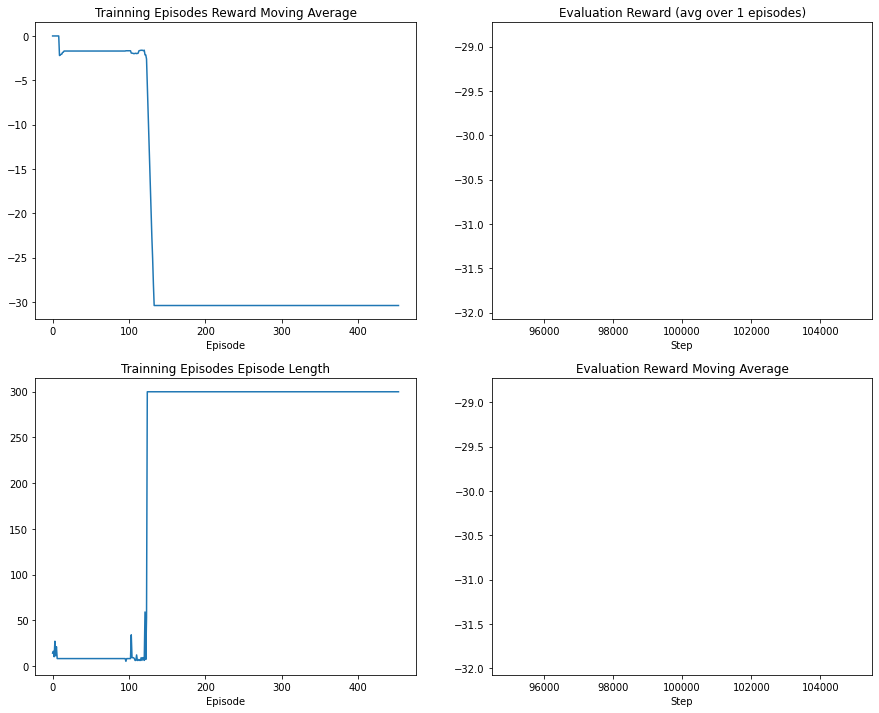

In [65]:
from IPython.display import Image
import ipyplot
import glob

# load best model 
best_model = DDPG.load("./logs/DummyMaze/best_model")

Evaluation.plot_train_eval_results("logs/DummyMaze", EVAL_EPISODES)
episode_reward = Evaluation.record_model(best_model, eval_maze_env, "logs/DummyMaze/final.avi")
print("Reward:", episode_reward)

Evaluation.create_gifs_from_avi("logs/DummyMaze")
gifs = glob.glob("logs/DummyMaze/*.gif")
labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
ipyplot.plot_images(gifs, labels, img_width=250)


# Gradually trainning

Up until here, it only worked to train the robot to get to the target when it starts really close to it. When taking it a little bit farther we would need a lot of luck to make it learn.

Here we are trying to train, and each *m* steps change the envrionment so the robot starts a little bit further from the target and the circle radius is a little bit bigger, and it has a little bit more steps so it can learn gradually.

In [74]:
BUFFER_SIZE = 1000 # smaller buffer for small task
# TOTAL_TIME_STEPS = 10000
LEARNING_RATE = 0.001

REWARDS = Rewards(target_arrival=1, collision=-1, timeout=-0.5)

EVAL_EPISODES=5
EVAL_FREQ=200
VIDEO_FREQ=5

CHANGE_ENV_EVERY = 1000

START_LOC_X = [5]*10
START_LOC_Y = np.around(np.linspace(3.3, 2.4, 10), 1)
START_LOCATIONS = list(zip(START_LOC_X, START_LOC_Y))
print("Start locations:\n", START_LOCATIONS)
# MAZE_RADIUSES = np.around(np.linspace(2.9, 3.8, 10), 1)
# print("Maze Radiuses:\n", MAZE_RADIUSES)
TIMEOUT_STEPS = np.linspace(150, 330, 10)
print("Timeout Steps:\n", TIMEOUT_STEPS)

Start locations:
 [(5, 3.3), (5, 3.2), (5, 3.1), (5, 3.0), (5, 2.9), (5, 2.8), (5, 2.7), (5, 2.6), (5, 2.5), (5, 2.4)]
Timeout Steps:
 [150. 170. 190. 210. 230. 250. 270. 290. 310. 330.]


## HER - Hindsight Experience Replay

After succeed in training the ant from relatively close place to the target (this is thanks to random success), we can observe that after moving the ant a little bit further from the target it is pretty hard to learn a long sequence of actions that will lead to goal arrival randomly.
We could optionally set the reward as a function of the distance to the target, but doing that will harm our reward sparsity, and make the reward much dense. We would like to achieve the same target with sparse reward (success or failure), for this mission we can use HER.
By using HER, we actually learn from unsuccessful episodes. The key insight that HER formalizes is what humans do intuitively: Even though we have not succeeded at a specific goal, we have at least achieved a different one.
When the RL algorithm (DDPG in our case) is wrong, we pretend that we wanted to achieve this goal (in our case, a different target location) if we repeat this process, we will eventually learn how to achieve arbitrary goals, including the goals that we really want to achieve. 


In [10]:
from stable_baselines3 import HerReplayBuffer

START_LOC = (5, 2.8)
TIMEOUT_STEPS = 300
BUFFER_SIZE = 1000 # smaller buffer for small task
TOTAL_TIME_STEPS = 10000
LEARNING_RATE = 0.001

REWARDS = Rewards(target_arrival=1, collision=-1, timeout=0)

EVAL_EPISODES=1
EVAL_FREQ=1000
VIDEO_FREQ=2

#HER parameters
N_SAMPLED = 4
STRATEGY = 'future' # futute, random or episode
ONLINE_SAMPLING = True

In [11]:
# create environment :
tile_size = 0.1
maze_size = mz.MazeSize.SQUARE10
map_size = np.dot(maze_size, int(1 / tile_size))
maze_map = make_circular_map(map_size, 4 / tile_size)
# maze_map = np.zeros(map_size)

maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                              maze_map=maze_map,
                              tile_size=tile_size,
                              start_loc=START_LOC,
                              target_loc=np.divide(maze_size, 2),
                              timeout_steps=TIMEOUT_STEPS,
                              show_gui=False,
                              rewards=REWARDS), 
                  filename="logs/DummyMaze/results")
_ = maze_env.reset()
check_env(maze_env)

# create separete evaluation environment:
eval_maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                                   maze_map=maze_map,
                                   tile_size=tile_size,
                                   start_loc=START_LOC,
                                   target_loc=np.divide(maze_size, 2),
                                   timeout_steps=TIMEOUT_STEPS,
                                   show_gui=False,
                                   rewards=REWARDS)
                       )
_ = eval_maze_env.reset()
 
# create model:
model = DDPG(policy="MultiInputPolicy",
             env=maze_env,
             buffer_size=BUFFER_SIZE,
             learning_rate=LEARNING_RATE,
             device='cuda',
             train_freq=(1, "episode"),
             replay_buffer_class=HerReplayBuffer,
             replay_buffer_kwargs=dict(
                 n_sampled_goal=N_SAMPLED,
                 goal_selection_strategy=STRATEGY,
                 online_sampling=ONLINE_SAMPLING,
                 max_episode_length=TIMEOUT_STEPS,
             ),
             verbose=1)

# create callback for evaluation
callback = EvalAndSaveCallback(log_dir="logs/DummyMaze",
                               eval_env=eval_maze_env,
                               eval_freq=EVAL_FREQ,
                               eval_episodes=EVAL_EPISODES,
                               eval_video_freq=VIDEO_FREQ,
                               verbose=1)

argv[0]=
argv[0]=
Using cuda device
Wrapping the env in a DummyVecEnv.


In [ ]:
start = time.time()

#clean all movies from the previous run
!rm -f logs/DummyMaze/*_steps.avi

torch.manual_seed(3295)
model.learn(total_timesteps=TOTAL_TIME_STEPS,
            callback=callback)
 
print("time", time.time() - start)

1000 Steps evaluation, avg reward:-1.0, avg episode length: 288.0
--Saving new best model--
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 297      |
|    ep_rew_mean     | -0.25    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 264      |
|    time_elapsed    | 4        |
|    total timesteps | 1188     |
| train/             |          |
|    actor_loss      | 0.235    |
|    critic_loss     | 0.000472 |
|    learning_rate   | 0.001    |
|    n_updates       | 900      |
---------------------------------
2000 Steps evaluation, avg reward:0.0, avg episode length: 300.0
--Saving new best model--
creating video
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 298      |
|    ep_rew_mean     | -0.125   |
| time/              |          |
|    episodes        | 8        |
|    fps             | 100      |
|    time_elapsed    | 23       |
|    total timesteps

In [ ]:
from IPython.display import Image
import ipyplot
import glob

# load best model 
best_model = DDPG.load("./logs/DummyMaze/best_model", env=maze_env)

Evaluation.plot_train_eval_results("logs/DummyMaze", EVAL_EPISODES)
episode_reward = Evaluation.record_model(best_model, eval_maze_env, "logs/DummyMaze/final.avi")
print("Reward:", episode_reward)

#Clean previous gifs
!rm -f logs/DummyMaze/*_steps.gif

# Plot gifs
Evaluation.create_gifs_from_avi("logs/DummyMaze")
gifs = glob.glob("logs/DummyMaze/*.gif")
labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
ipyplot.plot_images(gifs, labels, img_width=250)

### Re-evaluate the model on harder case

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
import os

# load best model 
best_model = DDPG.load("./logs/DummyMaze/best_model", env=maze_env)

# Define another  evaluation environment:

START_LOC = (5, 3)
TIMEOUT_STEPS = 500
REWARDS = Rewards(target_arrival=1, collision=-1, timeout=0)
EVAL_EPISODES = 1

tile_size = 0.1
maze_size = mz.MazeSize.SQUARE10
map_size = np.dot(maze_size, int(1 / tile_size))
maze_map = make_circular_map(map_size, 3 / tile_size)

fin_eval_maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                                   maze_map=maze_map,
                                   tile_size=tile_size,
                                   start_loc=START_LOC,
                                   target_loc=np.divide(maze_size, 2),
                                   timeout_steps=TIMEOUT_STEPS,
                                   show_gui=False,
                                   rewards=REWARDS)
                       )
_ = fin_eval_maze_env.reset()


# evaluate the model
rewards, lengths = evaluate_policy(best_model, fin_eval_maze_env, EVAL_EPISODES,
                                   deterministic=True, return_episode_rewards=True)

#create _ video
video_path = os.path.join("logs/DummyMaze/fin_eval", f'eval_steps.avi')
obs = fin_eval_maze_env.reset(create_video=True, video_path=video_path)
while True:
    action, _ = best_model.predict(obs, deterministic=True)
    obs, reward, done, _ = fin_eval_maze_env.step(action)
    if done:
        break
        
print("Reward:", rewards)
# #Clean previous gifs
os.makedirs("logs/DummyMaze/fin_eval", exist_ok=True)
!rm -f logs/DummyMaze/fin_eval/*_steps.gif

# # Plot gifs
Evaluation.create_gifs_from_avi("logs/DummyMaze/fin_eval")
gifs = glob.glob("logs/DummyMaze/fin_eval/*.gif")
labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
ipyplot.plot_images(gifs, labels, img_width=250)